C:\Users\swara\AppData\Local\Temp\ipykernel_13288\2585164239.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(TICKERS, start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  5 of 5 completed


Value at Risk (VaR) for the Portfolio:
  Confidence Level         VaR
0           90.00%  ₹16,129.84
1           95.00%  ₹21,142.94
2           99.00%  ₹30,393.84


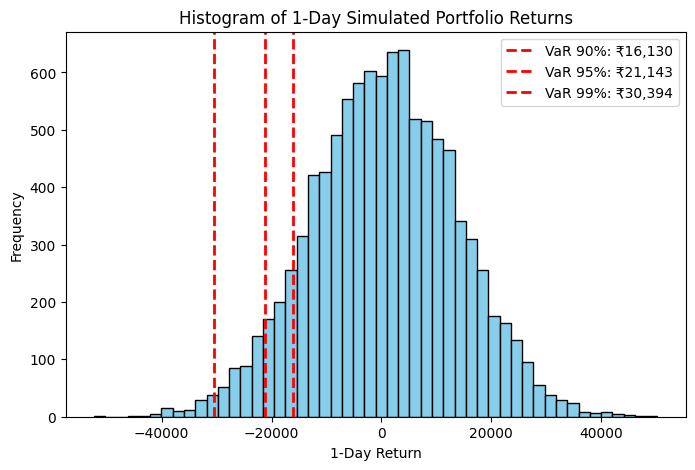

In [3]:
# ==========================
# Monte Carlo VaR Simulation
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

# --------------------------
# Parameters & Configuration
# --------------------------
YEARS = 5
TICKERS = ['INFY.NS', 'TCS.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS']
PORTFOLIO_VALUE = 1_000_000
DAYS = 1
SIMULATIONS = 10_000
CONFIDENCE_LEVELS = [0.90, 0.95, 0.99]

# --------------------------
# Data Retrieval
# --------------------------
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365 * YEARS)

prices = yf.download(TICKERS, start=start_date, end=end_date)['Close'].dropna()

# --------------------------
# Returns & Covariance
# --------------------------
log_returns = np.log(prices / prices.shift(1)).dropna()
cov_matrix = log_returns.cov()

# --------------------------
# Portfolio Metrics
# --------------------------
weights = np.array([1 / len(TICKERS)] * len(TICKERS))  # Equal weighting

def expected_return(weights: np.ndarray, log_returns: pd.DataFrame) -> float:
    """Calculate portfolio expected return."""
    return np.sum(log_returns.mean() * weights)

def portfolio_std(weights: np.ndarray, cov_matrix: pd.DataFrame) -> float:
    """Calculate portfolio standard deviation."""
    return np.sqrt(weights.T @ cov_matrix @ weights)

portfolio_mu = expected_return(weights, log_returns)
portfolio_sigma = portfolio_std(weights, cov_matrix)

# --------------------------
# Monte Carlo Simulation
# --------------------------
def simulate_portfolio_return(portfolio_value: float, mu: float, sigma: float, days: int) -> float:
    """Simulate a portfolio return using a random z-score."""
    z_score = np.random.normal(0, 1)
    return (portfolio_value * mu * days) + (portfolio_value * sigma * z_score * np.sqrt(days))

scenario_returns = [simulate_portfolio_return(PORTFOLIO_VALUE, portfolio_mu, portfolio_sigma, DAYS)
                    for _ in range(SIMULATIONS)]

# --------------------------
# Value at Risk Calculation
# --------------------------
VaRs = [
    round(-np.percentile(scenario_returns, (1 - cl) * 100), 2)
    for cl in CONFIDENCE_LEVELS
]

VaR_df = pd.DataFrame({
    'Confidence Level': CONFIDENCE_LEVELS,
    'VaR': VaRs
})

# Format only the VaR column
VaR_df['VaR'] = VaR_df['VaR'].apply(lambda x: f'₹{x:,.2f}')
VaR_df['Confidence Level'] = VaR_df['Confidence Level'].apply(lambda x: f'{x*100:,.2f}%')

# Display Results
print("Value at Risk (VaR) for the Portfolio:")
print(VaR_df)

# --------------------------
# Plot Results
# --------------------------
plt.figure(figsize=(8, 5))
plt.hist(scenario_returns, bins=50, color='skyblue', edgecolor='black')

for cl, var in zip(CONFIDENCE_LEVELS, VaRs):
    cutoff = -var  # Negative because losses
    plt.axvline(cutoff, color='red', linestyle='dashed', linewidth=2,
                label=f'VaR {int(cl*100)}%: ₹{var:,.0f}')

plt.title(f'Histogram of {DAYS}-Day Simulated Portfolio Returns')
plt.xlabel(f'{DAYS}-Day Return')
plt.ylabel('Frequency')
plt.legend(frameon=True, loc='upper right')
plt.show()